In [24]:
from lattice.ensemble import Ensemble
from lattice.protein_config import ProteinConfig
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from itertools import product
from concurrent.futures import ProcessPoolExecutor
import os
from collections import defaultdict

proteins = ['HHHHHHHHHH', 'HPHPPHPPHH', 'HPPHPPHPHH', 'PPPPPPHPPH', 'PPPPPHHHHH', 'PPPPPPPPPP']
ensembles = [Ensemble(protein) for protein in proteins]

def generate_sequences():
    sequences = [''.join(p) for p in product("HP", repeat=10)]
    sequences.sort(key=lambda s: (-s.count('H'), s))
    return sequences

def generate_all_ensembles_parallel(max_workers=None):
    sequences = generate_sequences()

    if max_workers is None:
        max_workers = os.cpu_count()

    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        all_ensembles = list(executor.map(Ensemble, sequences))

    return all_ensembles

all_ensembles = generate_all_ensembles_parallel()

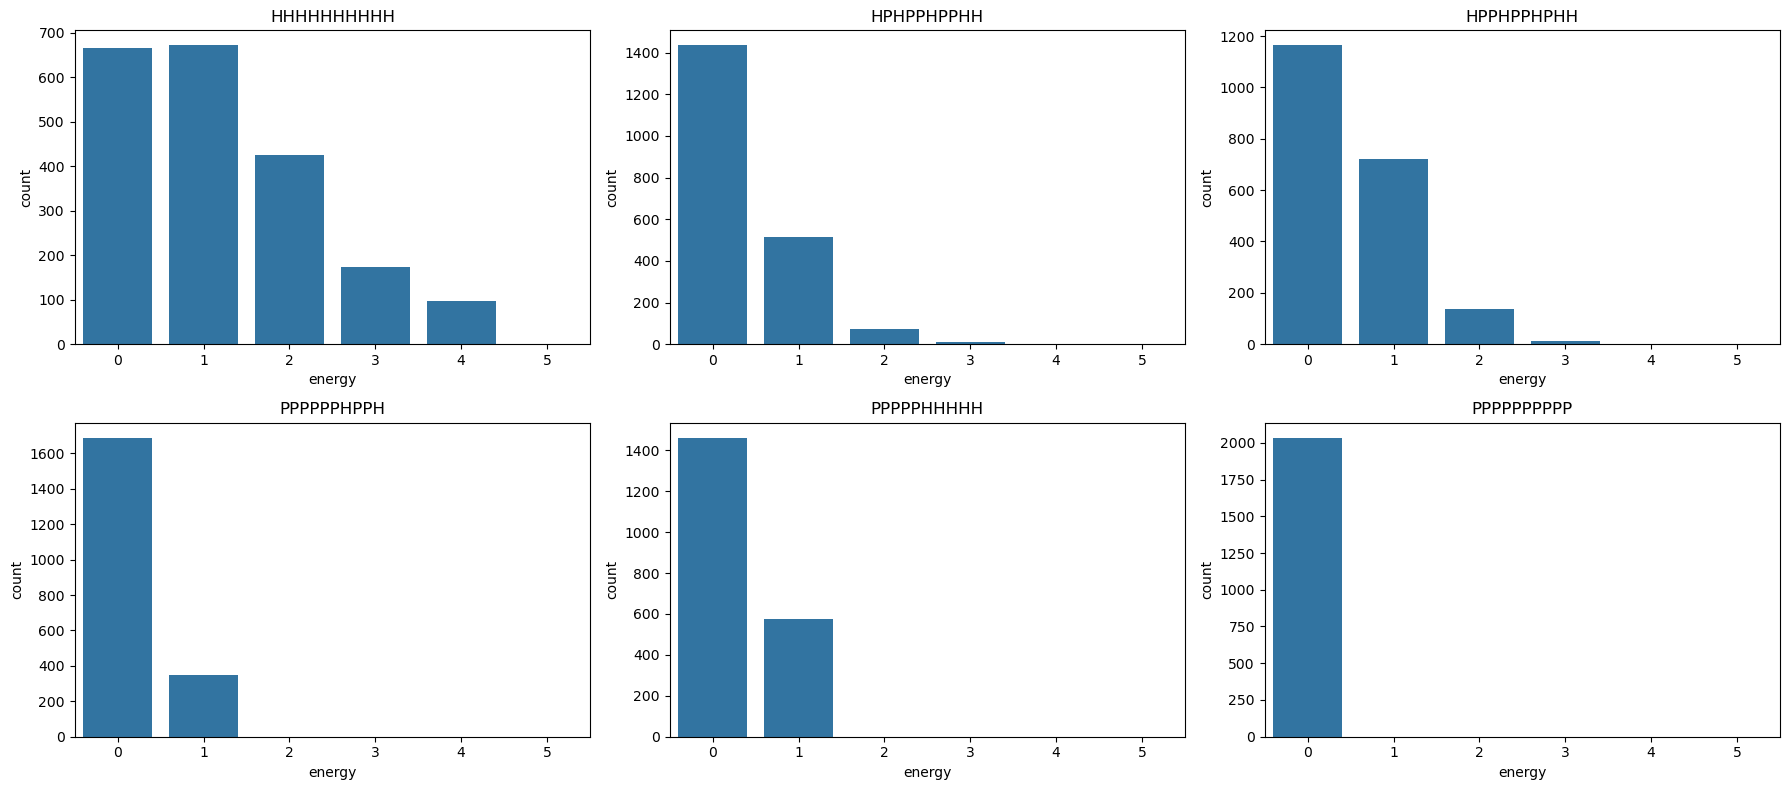

In [2]:
################
### Figure 2 ###
################

n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    sns.barplot(data=ens.degeneracies_df, x="count", y="energy", ax=ax)
    ax.set_title(ens.protein_string)
    ax.set_xlabel("energy")
    ax.set_ylabel("count")
    
plt.tight_layout()
plt.show()

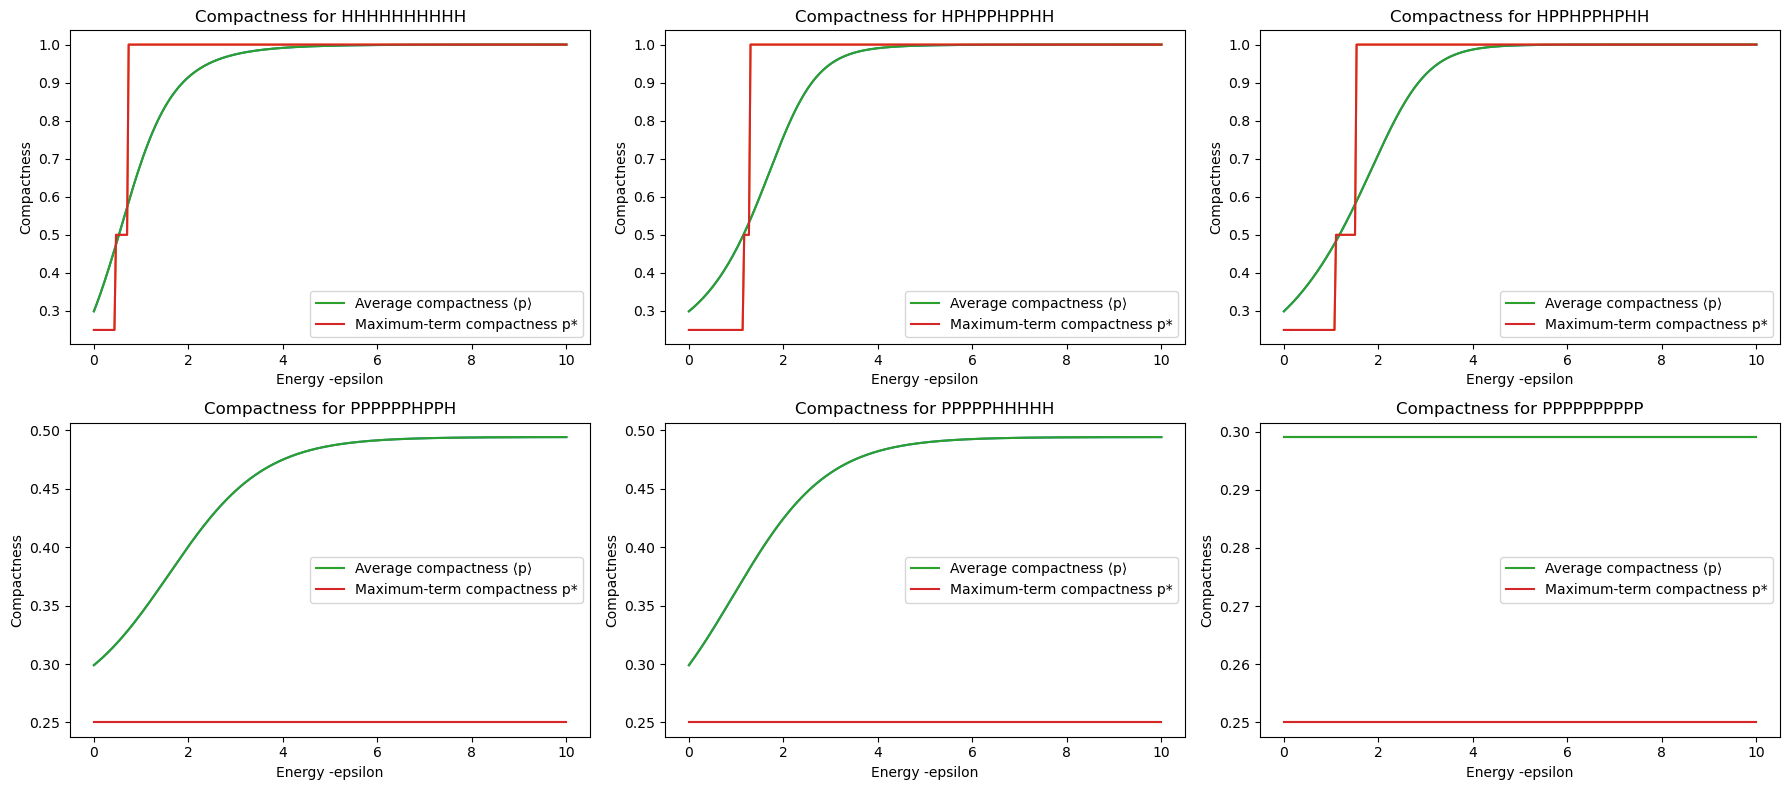

In [3]:
################
### Figure 3 ###
################

n = len(ensembles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, ensembles):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.p_average_compactness(-x) for x in xs]
    ys_max = [ens.p_maximum_term(-x) for x in xs]

    ax.plot(xs, ys)
    ax.plot(xs, ys_max)
    ax.plot(xs, ys, label="Average compactness ⟨p⟩")
    ax.plot(xs, ys_max, label="Maximum-term compactness p*")
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("Compactness")
    ax.set_title(f"Compactness for {ens.protein_string}")
    ax.legend()  # ← Add legend for this subplot

plt.tight_layout()
plt.show()

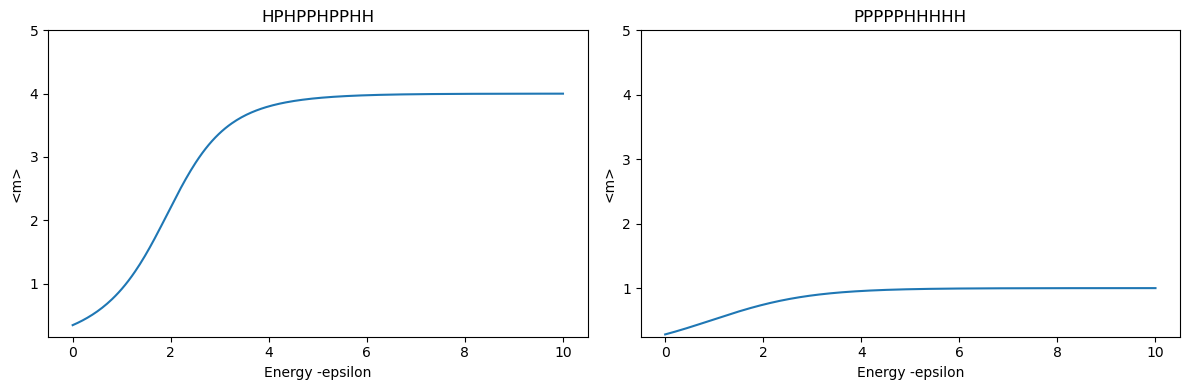

In [4]:
###################
### FIgure 4a,e ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.m_average_molecule_energy(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<m>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=5)

plt.tight_layout()
plt.show()

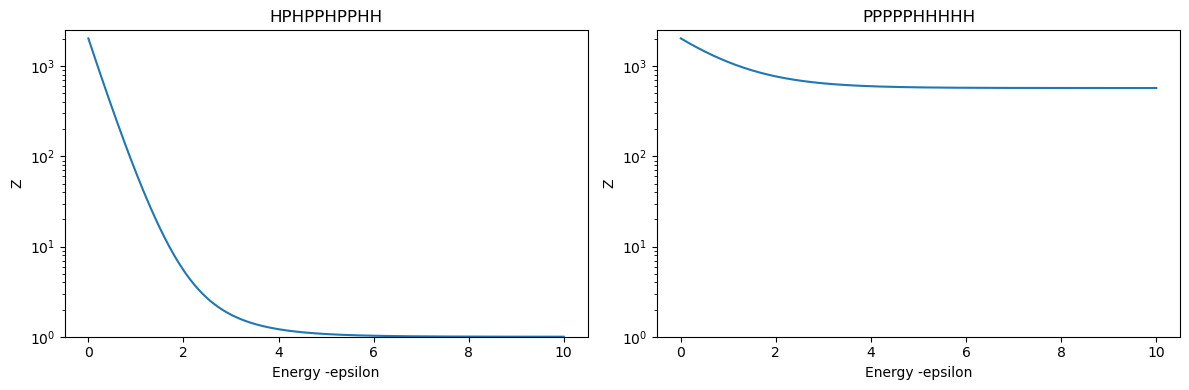

In [5]:
###################
### FIgure 4b,f ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.z_partition_function(epsilon=-x) for x in xs]

    ax.plot(xs, ys)
    ax.set_yscale("log")
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("Z")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(bottom=1, top=2500)

plt.tight_layout()
plt.show()

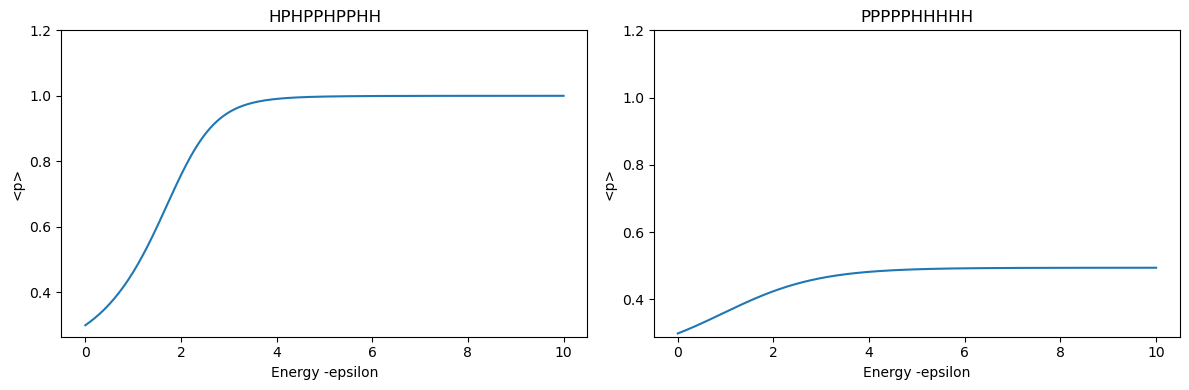

In [6]:
###################
### FIgure 4c,g ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.p_average_compactness(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<p>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=1.2)

plt.tight_layout()
plt.show()

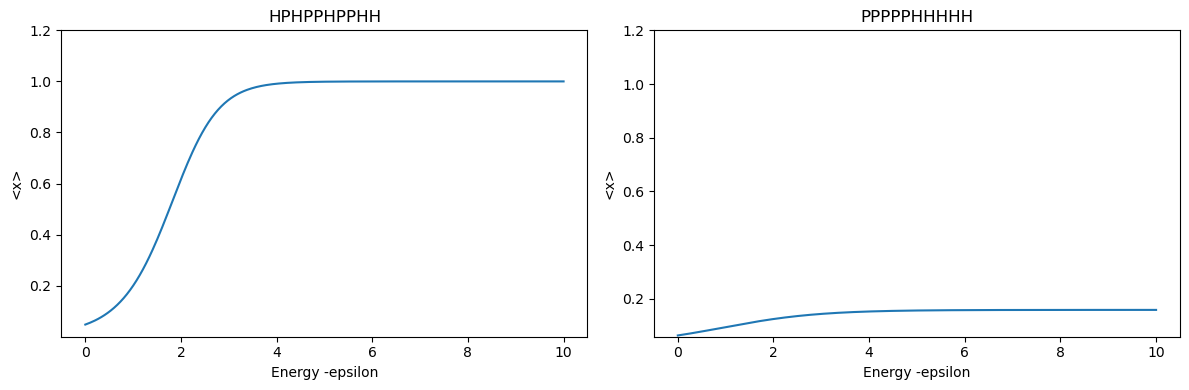

In [7]:
###################
### FIgure 4d,h ###
###################

n = len(ensembles)
cols = 2
rows = 1

fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 4 * rows))
axes = axes.flatten()

for ax, ens in zip(axes, [ensembles[1], ensembles[4]]):
    L = len(ens.protein_string)
    xs = np.linspace(0, L, 300)

    ys = [ens.x_average_core_distribution(-x) for x in xs]

    ax.plot(xs, ys)
    
    ax.set_xlabel("Energy -epsilon")
    ax.set_ylabel("<x>")
    ax.set_title(f"{ens.protein_string}")
    ax.set_ylim(top=1.2)

plt.tight_layout()
plt.show()

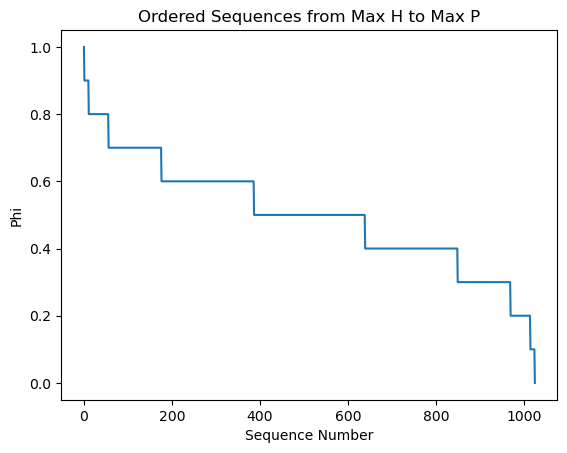

In [19]:
################
### FIgure 5 ###
################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.phi for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("Phi")
ax.set_title("Ordered Sequences from Max H to Max P")

plt.show()

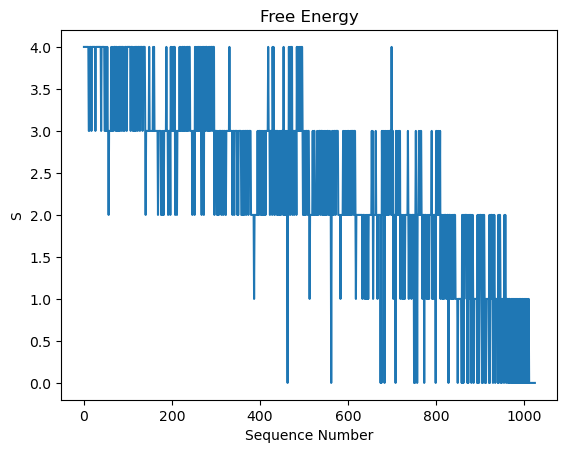

In [21]:
#################
### FIgure 6a ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.s_max_HH for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("S")
ax.set_title("Free Energy")

plt.show()

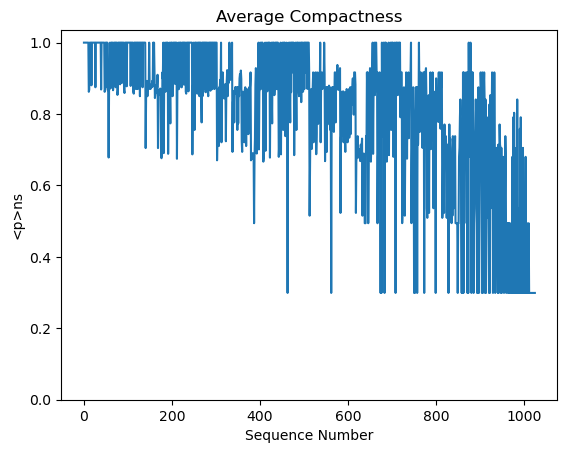

In [20]:
#################
### FIgure 6b ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.p_average_compactness_native_state for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("<p>ns")
ax.set_ylim(bottom=0)
ax.set_title("Average Compactness")


plt.show()

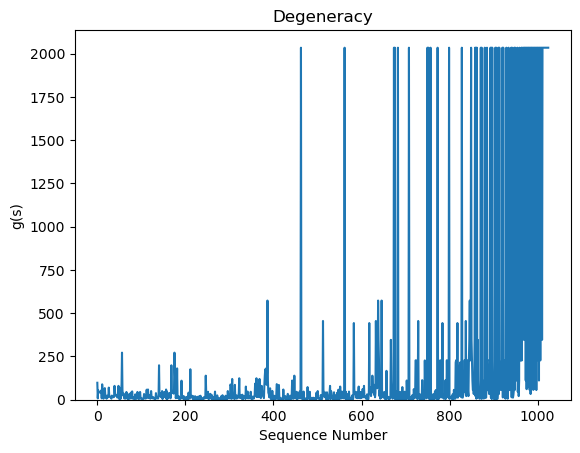

In [22]:
#################
### FIgure 6c ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.g_degeneracy(ensemble.s_max_HH) for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("g(s)")
ax.set_ylim(bottom=0)
ax.set_title("Degeneracy")

plt.show()

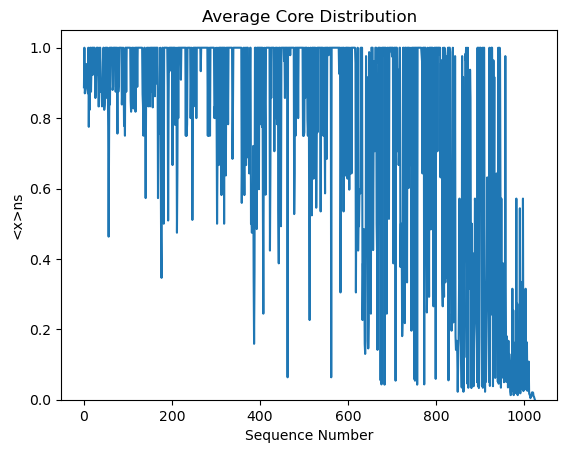

In [23]:
#################
### FIgure 6d ###
#################

fig, ax = plt.subplots()

xs = np.linspace(0, len(all_ensembles), len(all_ensembles))
ys = [ensemble.x_average_core_distribution_native_state for ensemble in all_ensembles]

ax.plot(xs, ys)
ax.set_xlabel("Sequence Number")
ax.set_ylabel("<x>ns")
ax.set_ylim(bottom=0)
ax.set_title("Average Core Distribution")

plt.show()

In [61]:
ensemble_dict = defaultdict(list)

for ensemble in all_ensembles:
    ensemble_dict[ensemble.phi].append(ensemble)

phis = []
ensembles = []

for phi, ens_list in ensemble_dict.items():
    phis.append(phi)
    ensembles.append(ens_list)

phis.reverse()
ensembles.reverse()

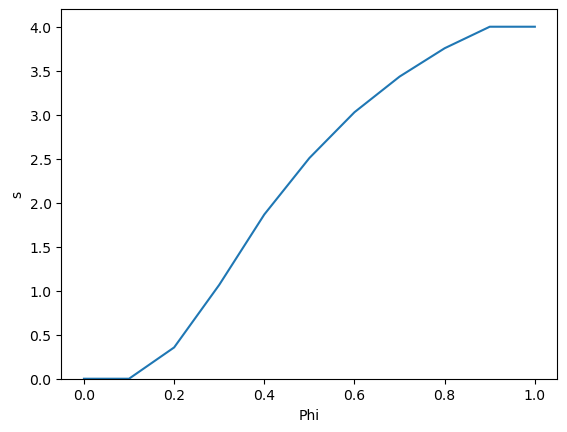

In [73]:
#################
### FIgure 7a ###
#################

fig, ax = plt.subplots()
ys = [sum(ensemble.s_max_HH for ensemble in collection) / len(collection) for collection in ensembles]

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("s")
ax.set_ylim(bottom=0)

plt.show()

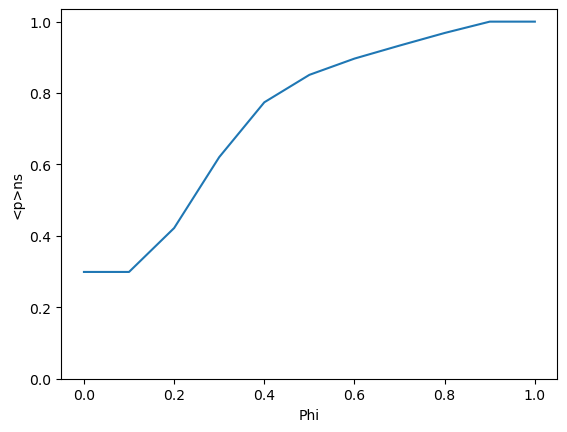

In [75]:
#################
### FIgure 7b ###
#################

fig, ax = plt.subplots()
ys = [sum(ensemble.p_average_compactness_native_state for ensemble in collection) / len(collection) for collection in ensembles]

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("<p>ns")
ax.set_ylim(bottom=0)

plt.show()

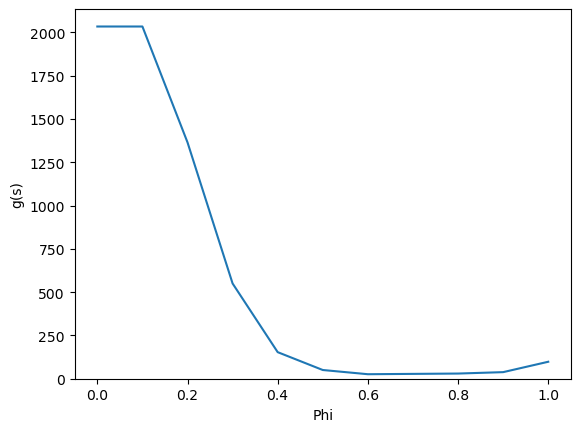

In [76]:
#################
### FIgure 7c ###
#################

fig, ax = plt.subplots()
ys = [sum(ensemble.g_degeneracy(ensemble.s_max_HH) for ensemble in collection) / len(collection) for collection in ensembles]

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("g(s)")
ax.set_ylim(bottom=0)

plt.show()

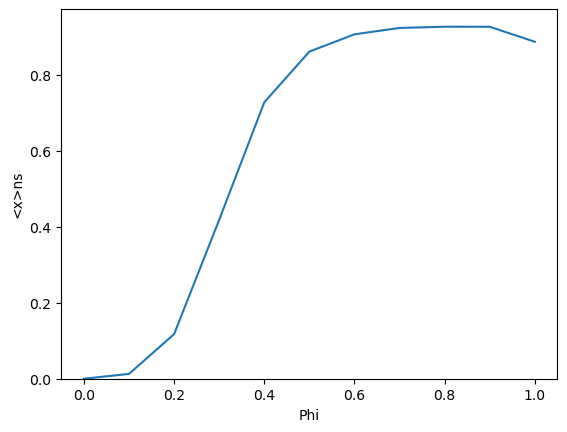

In [78]:
#################
### FIgure 7d ###
#################

fig, ax = plt.subplots()
ys = [sum(ensemble.x_average_core_distribution_native_state for ensemble in collection) / len(collection) for collection in ensembles]

ax.plot(phis, ys)
ax.set_xlabel("Phi")
ax.set_ylabel("<x>ns")
ax.set_ylim(bottom=0)

plt.show()

In [79]:
print(ys)

[0.0, 0.012733529990167159, 0.11761612688918827, 0.41888909297220617, 0.728400444445785, 0.8618920514883857, 0.9074237256933206, 0.9241478020458266, 0.9273752087052041, 0.927230220253476, 0.8877551020408162]
